# Palanca Literature Corpus Analysis with NLTK, NetworkX, and Seaborn
by Diogn Lei R. Mortera / @mortrpestl

## Part 1: Frequency Analysis Distribution

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from matplotlib import cm

from pathlib import Path

HERE = Path.cwd()
# https://matplotlib.org/stable/gallery/color/colormap_reference.html

In [ ]:
nltk.download() 
# uncomment above if you don't have nltk installed

df = pd.read_excel(HERE/"PalancaCorpus.xlsx")
df_dict = dict(df)

# --- NLP Setup ---
lemmatizer = WordNetLemmatizer()
stopwords_set = set(stopwords.words('english'))

fd_per_doc = {}
all_words = []
all_sentences = []
for doc_title, text_list in df_dict.items():
    tokens_filtered = []
    for text in text_list:
        if isinstance(text, str):
            all_sentences.append(text)
            tokens = word_tokenize(text.lower())
            tokens = [t for t in tokens if t.isalpha() and len(t) > 3]
            tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stopwords_set]
            tokens_filtered.extend(tokens)
            all_words.extend(tokens)
    fd_per_doc[doc_title] = FreqDist(tokens_filtered)

total_freq = FreqDist()
for fd in fd_per_doc.values():
    total_freq.update(fd)

top_n = 50
top_words = [word for word, _ in total_freq.most_common(top_n)]

freq_df = pd.DataFrame(index=fd_per_doc.keys(), columns=top_words).fillna(0)
for doc, fd in fd_per_doc.items():
    for word in top_words:
        freq_df.loc[doc, word] = fd[word]

freq_df_t = freq_df.T
freq_df_t['total'] = freq_df_t.sum(axis=1)
freq_df_t = freq_df_t.sort_values(by='total', ascending=False)
freq_df_t = freq_df_t[::-1]
freq_df_t = freq_df_t.drop(columns='total')

cmap = cm.get_cmap('RdYlGn', len(freq_df.index))
colors = [cmap(i) for i in range(len(freq_df.index))]

fig, ax = plt.subplots(figsize=(14, 12))
freq_df_t.plot(kind='barh', stacked=True, color=colors, ax=ax)
ax.xaxis.set_ticks(range(0, int(freq_df_t.sum(axis=1).max()) + 5, 5))
ax.xaxis.set_label_position('top')
ax.tick_params(axis='x', top=True, labeltop=True, labelbottom=True)
ax.tick_params(axis='y', left=False)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_title("'Palanca Awards' Word Frequency across Letters", fontsize=16)
ax.set_xlabel("Frequency", fontsize=12)
ax.set_ylabel("Words", fontsize=12)
ax.legend(title="Letter", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.savefig("palanca_freqanalysis.png", transparent=True)

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


## Part 2: Bonus Statistics Portion

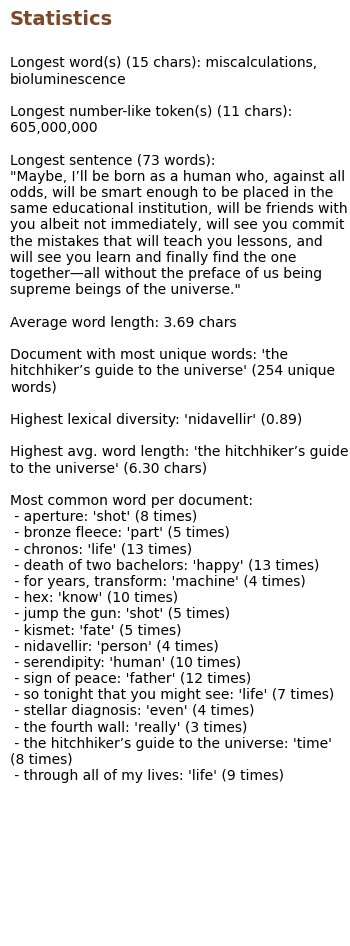

In [ ]:
import re

all_words_raw = []
all_sentences_raw = []

for text_list in df_dict.values():
    for text in text_list:
        if isinstance(text, str):
            all_sentences_raw.extend(sent_tokenize(text))
            all_words_raw.extend(word_tokenize(text))

def list_ties(items, key_func=len):
    if not items:
        return []
    max_len = max(map(key_func, items))
    return [item for item in items if key_func(item) == max_len]

all_alpha_words = [w for w in all_words_raw if w.isalpha()]
longest_words = list_ties(all_alpha_words)
longest_word_len = len(longest_words[0]) if longest_words else 0

all_number_like = [w for w in all_words_raw if re.search(r'\d', w) and ' ' not in w]
longest_numbers = list_ties(all_number_like)
longest_num_len = len(longest_numbers[0]) if longest_numbers else 0

longest_sentence = max(all_sentences_raw, key=lambda s: len(word_tokenize(s))) if all_sentences_raw else ""
longest_sentence_len = len(word_tokenize(longest_sentence)) if longest_sentence else 0

avg_word_len = sum(len(w) for w in all_words_raw) / len(all_words_raw) if all_words_raw else 0

unique_counts = {doc: len(set(fd)) for doc, fd in fd_per_doc.items()}
most_unique_doc = max(unique_counts, key=unique_counts.get) if unique_counts else ""
most_unique_count = unique_counts[most_unique_doc] if most_unique_doc else 0

lexical_diversity = {
    doc: len(set(fd)) / sum(fd.values()) for doc, fd in fd_per_doc.items() if sum(fd.values()) > 0
}
most_diverse_doc = max(lexical_diversity, key=lexical_diversity.get) if lexical_diversity else ""
most_diverse_score = lexical_diversity[most_diverse_doc] if most_diverse_doc else 0

avg_word_length_doc = {}
for doc, fd in fd_per_doc.items():
    all_doc_words = list(fd.elements())
    if all_doc_words:
        avg_len = sum(len(w) for w in all_doc_words) / len(all_doc_words)
        avg_word_length_doc[doc] = avg_len
most_complex_doc = max(avg_word_length_doc, key=avg_word_length_doc.get) if avg_word_length_doc else ""
most_complex_score = avg_word_length_doc[most_complex_doc] if most_complex_doc else 0
common_word_per_doc = {}
for doc, fd in fd_per_doc.items():
    if not fd:
        common_word_per_doc[doc] = "None"
        continue
    top_count = max(fd.values())
    top_words = [w for w,count in fd.items() if count == top_count]
    common_word_per_doc[doc] = f"{', '.join(sorted(top_words))} ({top_count})"
common_word_per_doc = "\n".join(f"'{doc}': {word}" for doc,word in common_word_per_doc.items())

fig, ax = plt.subplots(figsize=(3.5, 10))
ax.axis('off')

ax.text(0, 1, "Statistics", fontsize=14, fontweight='bold', color='#7C482B', va='top', ha='left')

stats_text = (
    f"Longest word(s) ({longest_word_len} chars): {', '.join(set(longest_words))}\n\n"
    f"Longest number-like token(s) ({longest_num_len} chars): "
    f"{', '.join(set(longest_numbers)) if longest_numbers else 'None'}\n\n"
    f"Longest sentence ({longest_sentence_len} words):\n\"{longest_sentence}\"\n\n"
    f"Average word length: {avg_word_len:.2f} chars\n\n"
    f"Document with most unique words: '{most_unique_doc}' ({most_unique_count} unique words)\n\n"
    f"Highest lexical diversity: '{most_diverse_doc}' ({most_diverse_score:.2f})\n\n"
    f"Highest avg. word length: '{most_complex_doc}' ({most_complex_score:.2f} chars)\n\n"
    "Most common word per document:\n"
    f"{common_word_per_doc}"
)

ax.text(0, 0.95, stats_text, fontsize=10, color='#000000', va='top', ha='left', wrap=True, fontfamily='DejaVu Sans')

plt.tight_layout()
plt.savefig("palanca_stats.png", transparent=True)
plt.show()



## Part 3: Word Cloud

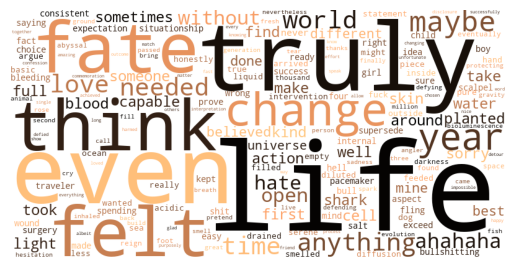

In [ ]:
from wordcloud import WordCloud

text = " ".join(tokens)
wc = WordCloud(
width=800,
height=400,
background_color='white',    
colormap='copper',             
prefer_horizontal=1.0,
max_words=200
).generate(text)

plt.imshow(wc, interpolation='antialiased')
plt.axis('off')

plt.savefig("palanca_wordcloud.jpg", transparent=True)
plt.show()

## Part 4: Graph Representation
Shows which words appear on the documents. The more it appears on a document, the closer it is to the node.

C:\Users\mortrpestl\AppData\Local\Temp\ipykernel_5804\3101030259.py:39: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')


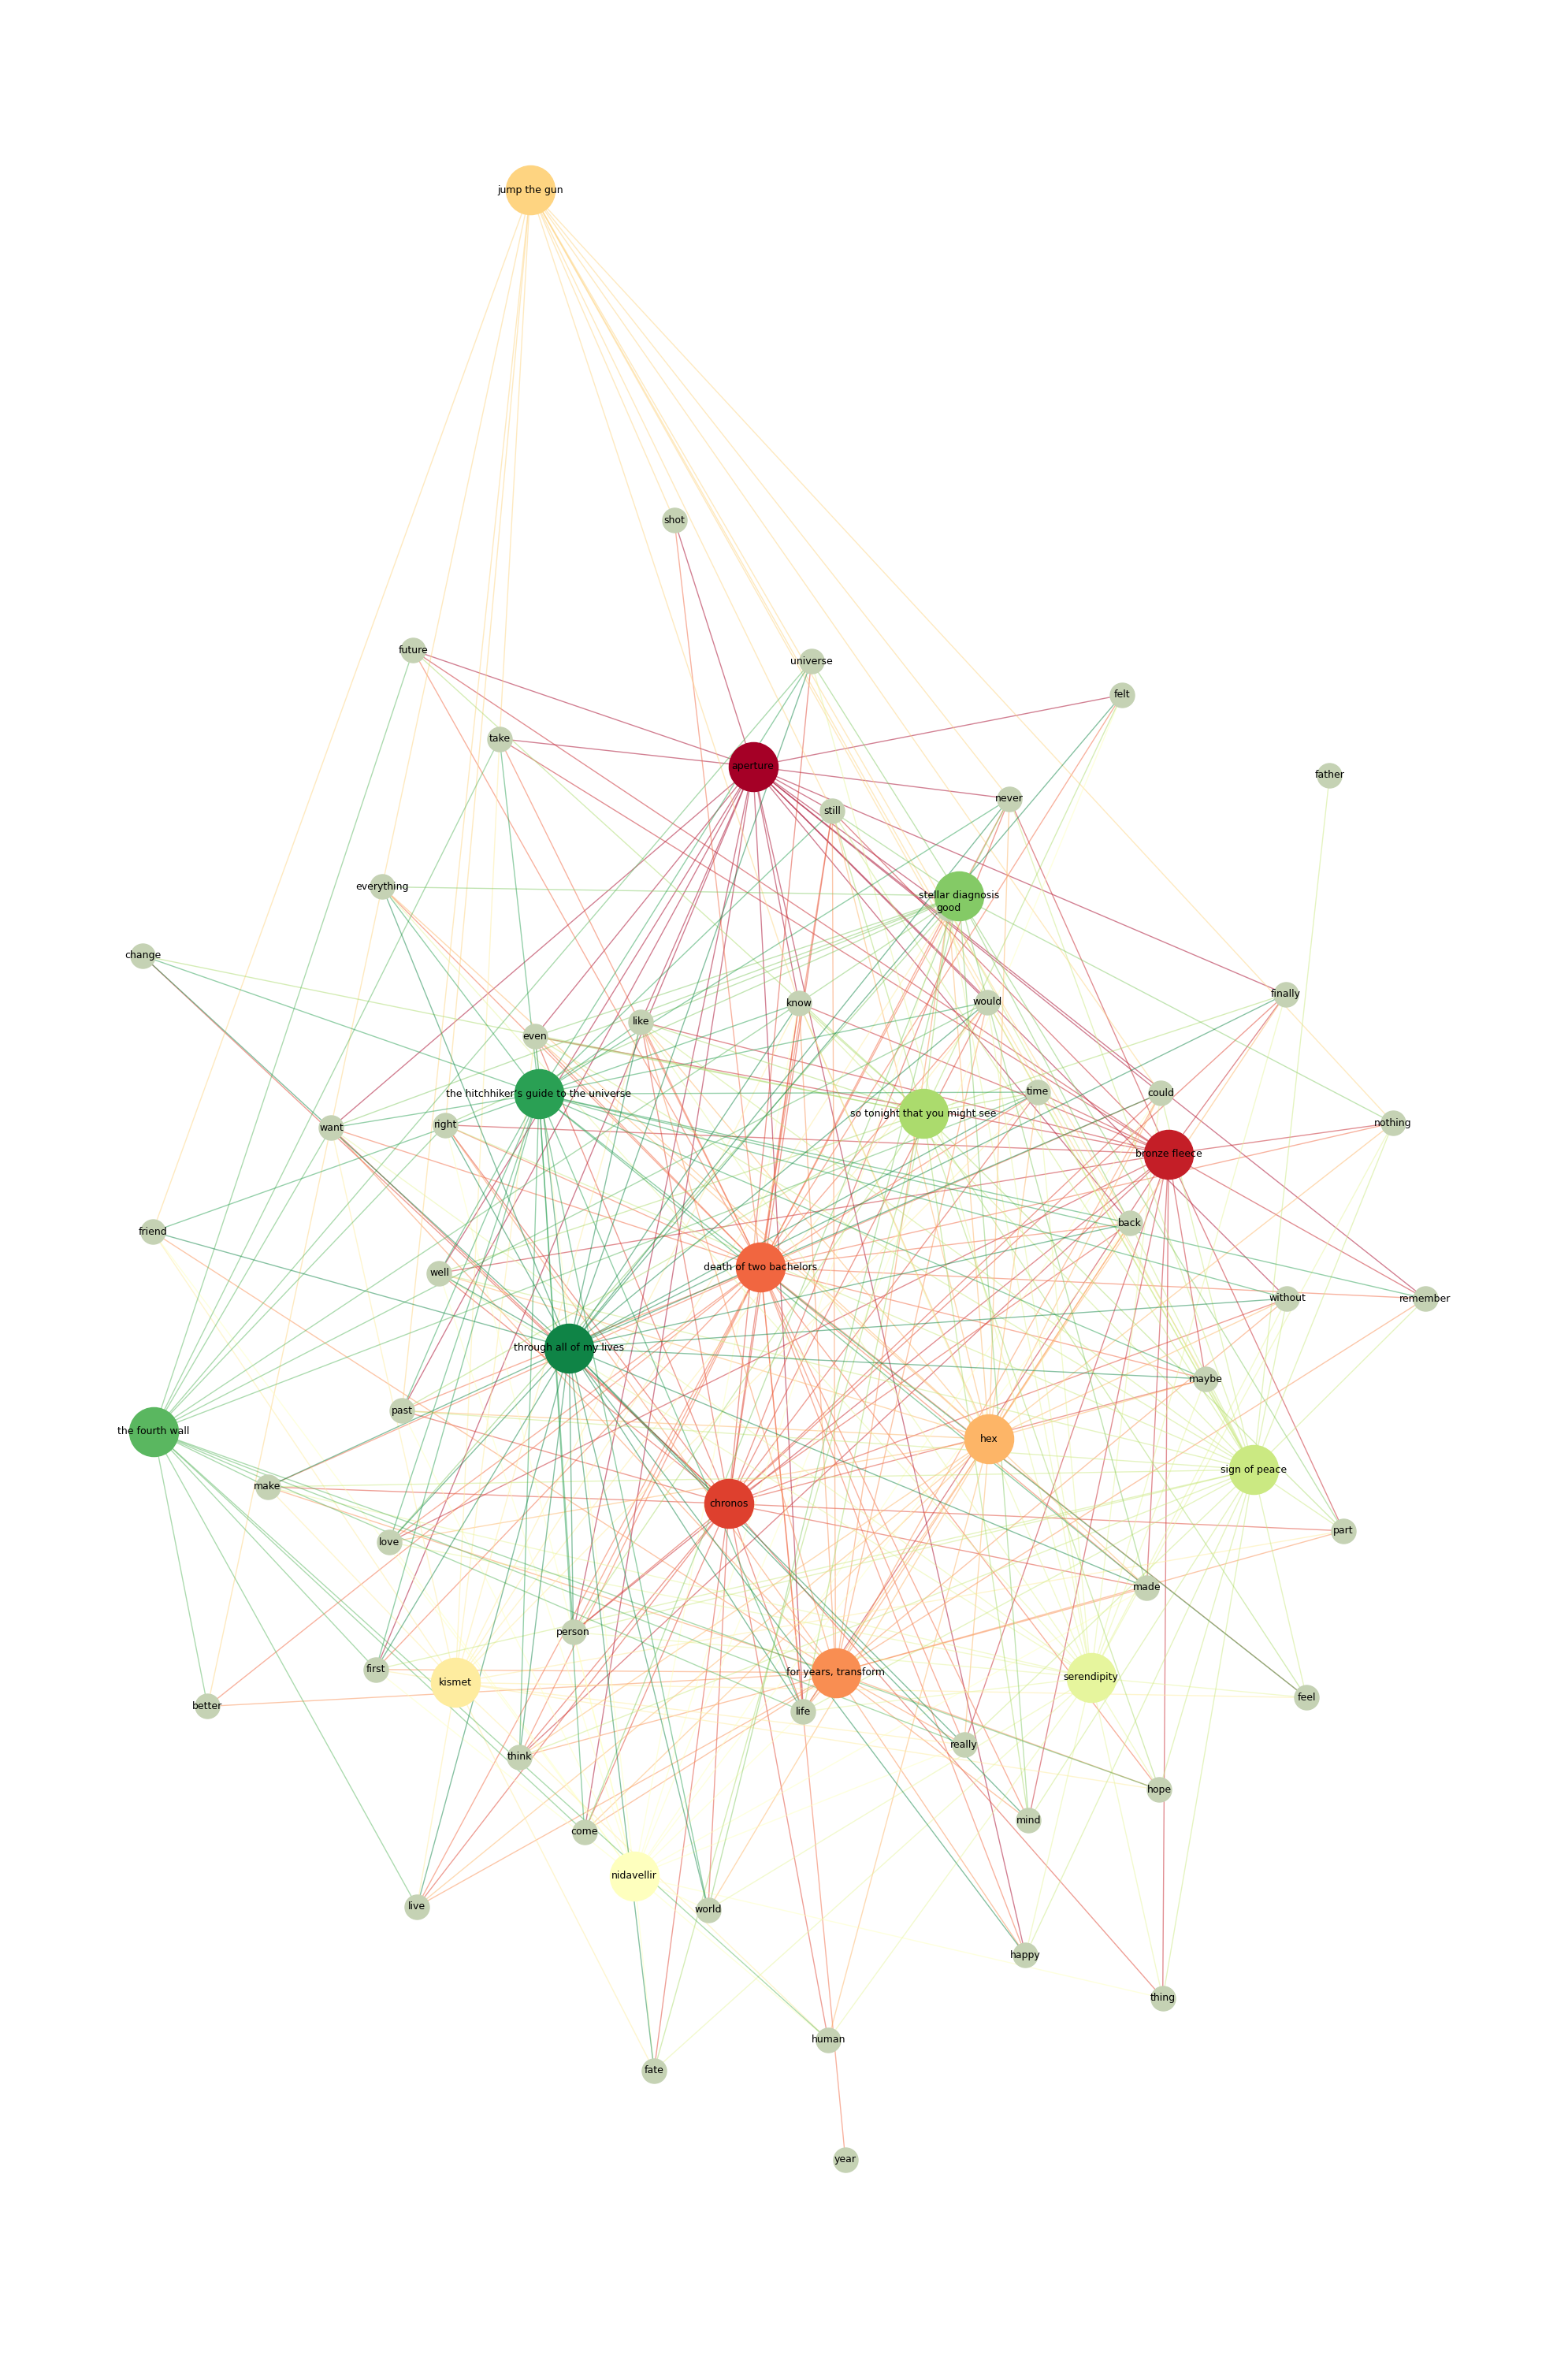

In [ ]:
## Part 3: Co-Occurrence Network Analysis of the different documents

import networkx as nx

# cleaning data
fd_mostcommon_w = [x[0] for x in FreqDist(dist).most_common(50)]
df = pd.read_excel(r'C:\Users\mortrpestl\Desktop\Archives\mortrpestl\Recreational\Programming\ML Projects\PalancaCorpus.xlsx')
df_dict = dict(df)
df_dict_cleaned = dict()

for dd in df_dict:
    temp_ = set()
    for s in df_dict[dd]:
        if isinstance(s, str): 
            tokens = word_tokenize(s.lower()) 
            for token in tokens:
                if token in fd_mostcommon_w:
                    temp_.add(token)
    df_dict_cleaned[dd] = temp_

G = nx.Graph()

for doc, words in df_dict_cleaned.items():
    G.add_node(doc, type='document')
    for word in words:
        G.add_node(word, type='word')
        G.add_edge(doc, word) 

pos = nx.spring_layout(G, seed=383838383, k=0.8) 

for node in pos:
    if G.nodes[node]['type'] == 'document':
        pos[node] = (pos[node][0] * 2.5, pos[node][1] * 2.5)  

doc_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'document']
word_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'word']

num_docs = len(doc_nodes)
cmap = cm.get_cmap('RdYlGn')
doc_colors = {doc: cmap(i / num_docs) for i, doc in enumerate(doc_nodes)}

pos = nx.spring_layout(G, seed=0, k=1.2)
for node in pos:
    if G.nodes[node]['type'] == 'document':
        pos[node] = (pos[node][0] * 2.5, pos[node][1] * 2.5)

plt.figure(figsize=(20, 30))

nx.draw_networkx_nodes(G, pos, nodelist=word_nodes, node_color='#c5d2b4', node_size=500, label='Words')

for doc in doc_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[doc], node_color=[doc_colors[doc]], node_size=2000)
    edges = [(doc, nbr) for nbr in G.neighbors(doc) if G.nodes[nbr]['type'] == 'word']
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=[doc_colors[doc]], width=1, alpha=0.5)

labels = {n: n for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9)

plt.axis('off')
plt.tight_layout()

plt.savefig("palanca_network.png", transparent=True)

plt.show()



## Part 5: Radial Network Representation
A better visualization of the network in Part 4. The same paradigms (the closer, the more frequent and etc.) apply

C:\Users\mortrpestl\AppData\Local\Temp\ipykernel_5804\1067865221.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('RdYlGn')


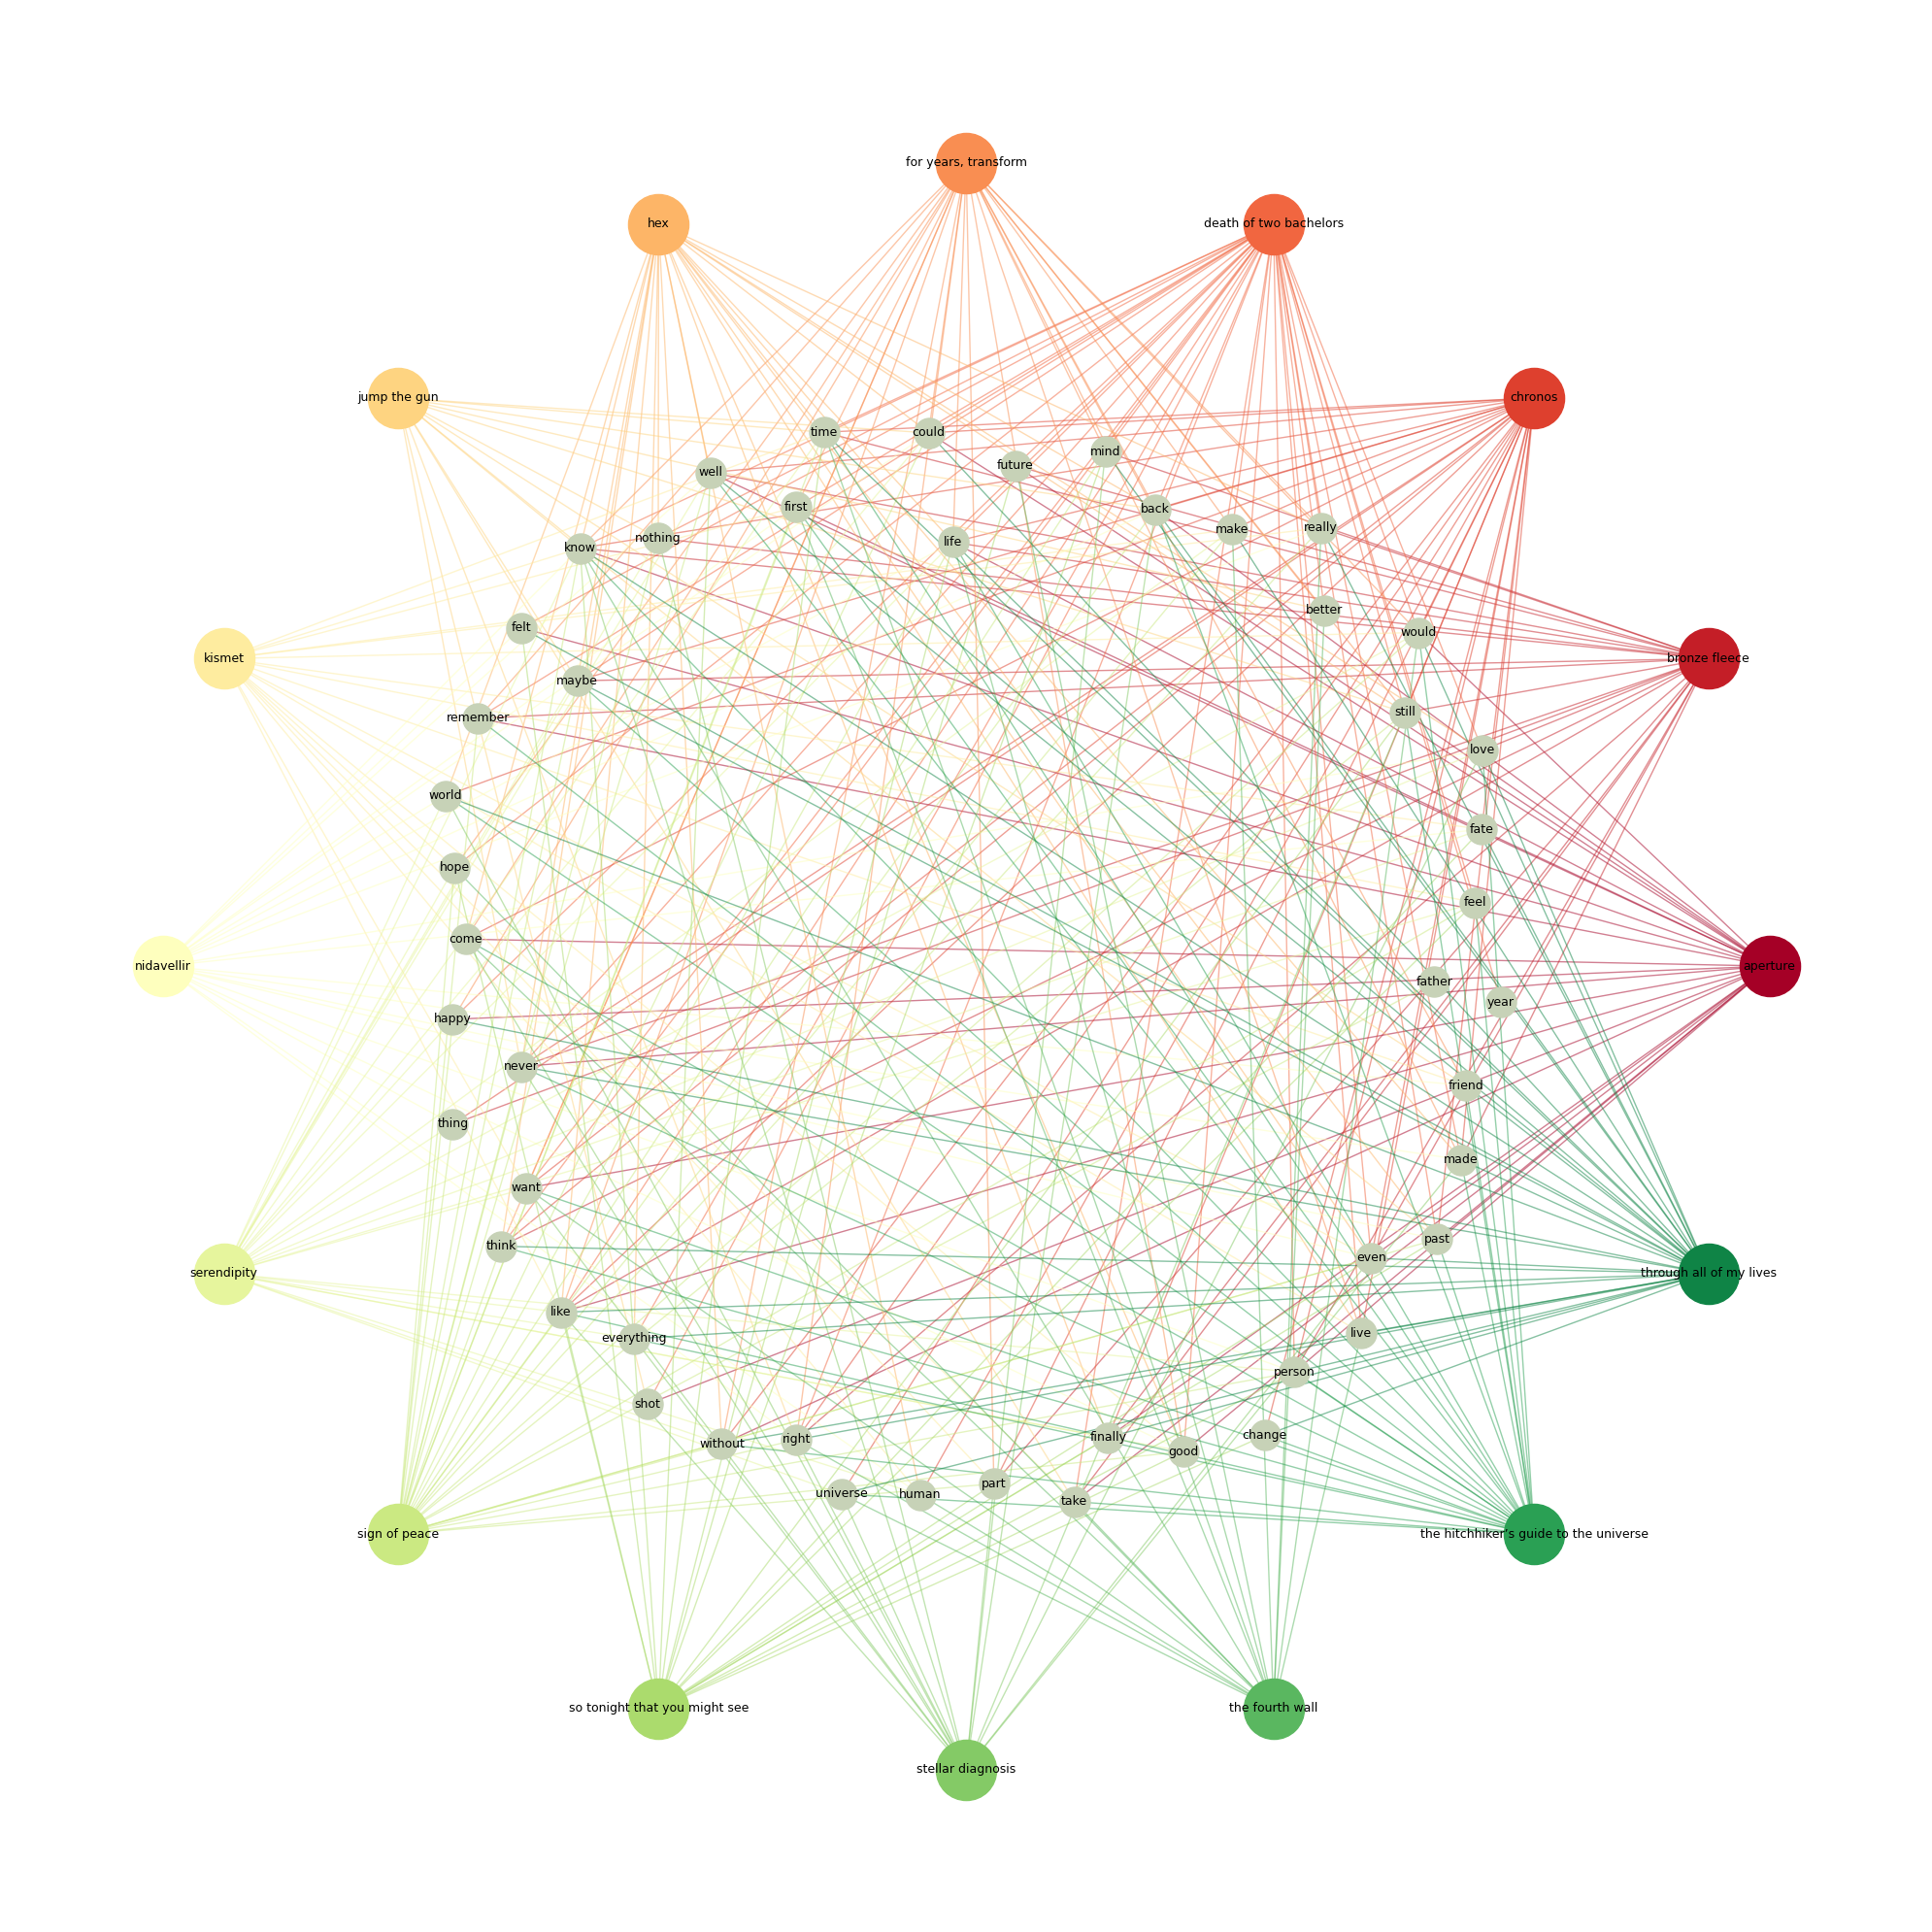

In [ ]:
import numpy as np
import networkx as nx

word_subgraph = G.subgraph(word_nodes)
word_pos = nx.spring_layout(word_subgraph, k=0.2, seed=42)

doc_radius = 1.5 
doc_pos = {}
angle_step = 2 * np.pi / len(doc_nodes)
for i, doc in enumerate(doc_nodes):
    angle = i * angle_step
    doc_pos[doc] = (doc_radius * np.cos(angle), doc_radius * np.sin(angle))

pos = {**word_pos, **doc_pos}

num_docs = len(doc_nodes)
cmap = cm.get_cmap('RdYlGn')
doc_colors = {doc: cmap(i / num_docs) for i, doc in enumerate(doc_nodes)}

plt.figure(figsize=(20, 20))

nx.draw_networkx_nodes(G, pos, nodelist=word_nodes, node_color='#c7d2b7', node_size=500)
for doc in doc_nodes:
    nx.draw_networkx_nodes(G, pos, nodelist=[doc], node_color=[doc_colors[doc]], node_size=2000)

for doc in doc_nodes:
    edges = [(doc, word) for word in G.neighbors(doc)]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color=[doc_colors[doc]], width=1, alpha=0.5)

labels = {n: n for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9) #, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

plt.axis('off')
plt.tight_layout()
plt.savefig("palanca_radial_network.png", transparent=True)
plt.show()
